# Analysis of Mouse Adipose Data Set

## Table of contents:

* <a href=#Load>Load Packages and Set Global Variables</a>
    * <a href=#Imports>Imports and Settings</a>
    * <a href=#Global>Global Variables</a> 
* <a href=#Dataloading>Loading Data, Quality Control and Preprocessing</a>
* <a href=#Define>Define Cell Types</a>
* <a href=#adipocytes>Adipocytes Only</a>
    * <a href=#Embedding>Embeddings and Clustering</a>
    * <a href=#adipmarkers>Adipocyte Marker Analysis</a>
    * <a href=#topde>Top ranking DE Genes</a>
    * <a href=#count_dist>Count distribution for Tcf25, Bin1 and Eif5</a>
* <a href=#traject>Preadipocytes only</a>

<a id="Load"></a>

# Load Packages and Set Global Variables

<a id="imports"></a>

## Imports and Settings

In [2]:
import numpy as np
import scanpy as sc
import sys
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import colors
from gprofiler import GProfiler

In [3]:
base_dir = '/Users/viktorian.miok/Documents/consultation/Ruth/David/data/bat/MUC8387/'
dir_out = '/Users/viktorian.miok/Documents/consultation/Ruth/David/results/'

sc.settings.verbosity = 3 # amount of output
dir_in = base_dir+'mm10_ensrel94/'
dir_tables = dir_out+'tables/'
sc.settings.figdir = dir_out+'panels/'
dir_adata = dir_out+'anndata/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, scanpy=True)
print (sys.version)

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
PyObjCTools         NA
anndata             0.7.5
appnope             0.1.2
backcall            0.2.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dask                2021.03.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
gprofiler           1.0.0
h5py                3.2.1
idna                2.10
igraph              0.9.0
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.17.2
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.36.0
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.53.0
numexpr             2.7.3
numpy               1.20.1
packaging           20.

In [4]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Blues(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## Global Variables

All embeddings and clusterings can be saved and loaded into this script. Be carful with overwriting cluster caches as soon as cell type annotation has started as cluster labels may be shuffled.

Set whether anndata objects are recomputed or loaded from cache.

In [5]:
bool_recomp = False

Set whether clustering is recomputed or loaded from saved .obs file. Loading makes sense if the clustering changes due to a change in scanpy or one of its dependencies and the number of clusters or the cluster labels change accordingly.

In [6]:
bool_recluster = False

Set whether cluster cache is overwritten. Note that the cache exists for reproducibility of clustering, see above.

In [7]:
bool_write_cluster_cache = False

Set whether to produce plots, set to False for test runs.

In [8]:
bool_plot = False

Set whether observations should be calculated. If false, it is necessary to read cacheed file that contains the necssary information. It then shows the the distributions of counts and genes, as well as mt_frac after filtering. 
Set to true in order to see the data before filtering and follow the decisions for cutoffs.

In [9]:
bool_create_observations = True

<a id="Dataloading"></a>

# Loading Data, Quality Control and Preprocessing

Read the data in:

In [10]:
adata_raw = sc.read(dir_in+'raw_gene_bc_matrices.h5ad')

<a id="QC"></a>

## Quality Control

Summary of steps performed here: Only cells with at least 500 UMIs are kept. Counts per cell are cell library depth normalized. The gene (feature) space is reduced with PCA to 50 PCs. A nearest neighbour graph and umap are computed based on the PC space. Cell are clustered with louvain clustering based on the nearest neighbour graph. Graph abstraction is computed based on the louvain clustering.

In [11]:
adata_raw.shape

(737280, 31125)

The data contains 737280 observations with 31125 different genes. Due to dropouts, some of the observations might not show any counts and genes. In order to calculate the fraction of mitochondrial RNA in the next steps, each observations without counts must be filtered out to prevent NaN from emerging. 

In [12]:
print('Total number of cells: {:d}'.format(adata_raw.n_obs))

sc.pp.filter_cells(adata_raw, min_counts = 1)
print('Number of cells after min count filter: {:d}'.format(adata_raw.n_obs))

adata_raw.shape

filtered out 352632 cells that have less than 1 counts


Total number of cells: 737280
Number of cells after min count filter: 384648


(384648, 31125)

From the 737280 observations, only 384648 are left with counts greater than 0, which is ~52%.

<a id="n_gen_counts"></a>

### Gene numbers and counts with and without mitochondrial RNA

Create necessary obs:

In [13]:
adata_qc = adata_raw.copy()
adata_qc.obs['n_genes'] = (adata_qc.X > 0).sum(1)
mt_gene_mask = [gene.startswith('mt-') for gene in adata_qc.var_names]
temp_mt_sum = adata_qc[:,mt_gene_mask].X.sum(1)
temp_mt_sum = np.squeeze(np.asarray(temp_mt_sum))
temp_n_counts = adata_qc.obs['n_counts']
adata_qc.obs['mt_frac'] = temp_mt_sum/adata_qc.obs['n_counts']

Plot n_counts and mt_frac:

In [14]:
if bool_plot == True:
    t1 = sc.pl.violin(adata_qc, 'n_counts', size =2 ,log=True, cut = 0)
    t2 = sc.pl.violin(adata_qc, 'mt_frac')

Overall, the data contains a lot of observations with high fractions of mitochondrial RNA. Additionally, most observations show counts below 100, suggesting poor data quality. To further investigate the distributions counts over genes per observations, scatterplots are created:

### Number of Genes versus Number of Counts

In [15]:
if bool_plot == True:
    p1 = sc.pl.scatter(adata_qc, 'n_counts','n_genes',color='mt_frac', size = 5)
    p2 = sc.pl.scatter(adata_qc[adata_qc.obs['n_counts']<10000],'n_counts','n_genes',color = 'mt_frac', size = 5)
    p3 = sc.pl.scatter(adata_qc[adata_qc.obs['n_counts']<1000],'n_counts','n_genes',color = 'mt_frac', size = 5)

### Distribution of Counts and Genes

In [16]:
if bool_plot == True:
    p6 = sb.distplot(adata_qc.obs['n_counts'], kde = False)
    plt.show()
    p7 = sb.distplot(adata_qc.obs['n_counts'][adata_qc.obs['n_counts']<1000], kde = False)
    plt.show()
    p8 = sb.distplot(adata_qc.obs['n_counts'][adata_qc.obs['n_counts']<100], kde = False)
    plt.show()

In [17]:
if bool_plot == True:
    p9 = sb.distplot(adata_qc.obs['n_genes'],kde = False, bins=60)
    plt.show()
    p10 = sb.distplot(adata_qc.obs['n_genes'][adata_qc.obs['n_genes']<100],kde = False, bins=60)
    plt.show()

### Filtering

In [18]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_qc.n_obs))

sc.pp.filter_cells(adata_qc, min_counts = 200)
print('Number of cells after min count filter: {:d}'.format(adata_qc.n_obs))

sc.pp.filter_cells(adata_qc, max_counts = 15000)
print('Number of cells after max count filter: {:d}'.format(adata_qc.n_obs))

adata_qc = adata_qc[adata_qc.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata_qc.n_obs))

sc.pp.filter_cells(adata_qc, min_genes = 100)
print('Number of cells after gene filter: {:d}'.format(adata_qc.n_obs))




filtered out 380040 cells that have less than 200 counts
filtered out 32 cells that have more than 15000 counts
filtered out 150 cells that have less than 100 genes expressed
Trying to set attribute `.obs` of view, copying.


Total number of cells: 384648
Number of cells after min count filter: 4608
Number of cells after max count filter: 4576
Number of cells after MT filter: 4163
Number of cells after gene filter: 4013


Only 4013 observations are left that pass the filters.

In [19]:
if bool_plot == True:
    p12 = sc.pl.scatter(adata_qc, 'n_counts','n_genes',color='mt_frac', size = 5)
    p22 = sc.pl.scatter(adata_qc[adata_qc.obs['n_counts']<10000],'n_counts','n_genes',color = 'mt_frac', size = 5)
    p52 = sc.pl.scatter(adata_qc[adata_qc.obs['n_counts']<1000],'n_counts','n_genes',color = 'mt_frac', size = 5)


In [20]:
if bool_plot == True:
    sc.pl.violin(adata_qc, 'n_counts', size=2, log=True, cut=0)
    sc.pl.violin(adata_qc,'mt_frac')

For the remaining observations, the fraction of mitochondrial RNA is generally very low and at most 20%

In [21]:
if bool_plot == True:
    p62 = sb.distplot(adata_qc.obs['n_counts'], kde = False)
    plt.show()
    p72 = sb.distplot(adata_qc.obs['n_counts'][adata_qc.obs['n_counts']<1000], kde = False)
    plt.show()

In [22]:
if bool_plot == True:
    p92= sb.distplot(adata_qc.obs['n_genes'],kde = False, bins=60)
    plt.show()
    p100 = sb.distplot(adata_qc.obs['n_genes'][adata_qc.obs['n_genes']<1000],kde = False, bins=60)
    plt.show()

In [23]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_qc.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_qc, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_qc.n_vars))

filtered out 18501 genes that are detected in less than 20 cells


Total number of genes: 31125
Number of genes after cell filter: 12624


<a id="normalization_and_clustering"></a>

## Normalization and Clustering with highly variable genes

In [24]:
if bool_recomp == True:
        
    adata_proc = adata_qc.copy()
    adata_proc.raw = adata_proc
    sc.pp.normalize_per_cell(adata_proc)
    sc.pp.log1p(adata_proc)
    sc.pp.highly_variable_genes(adata_proc, flavor='cell_ranger',n_top_genes=4000)
    sc.pl.highly_variable_genes(adata_proc)
   
    sc.pp.pca(adata_proc, n_comps=50, random_state=0, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(adata_proc, n_neighbors=100, knn=True, method='umap', n_pcs=50, random_state=0)
    #sc.tl.tsne(adata_proc, n_jobs=3)
    sc.tl.umap(adata_proc)
    if bool_recluster == True:
        sc.tl.louvain(adata_proc, resolution=1, flavor='vtraag', random_state=0)
        pd.DataFrame(adata_proc.obs).to_csv(path_or_buf =dir_adata+"obs_adata_proc.csv")
    else:
        obs = pd.read_csv(dir_adata+'obs_adata_proc.csv')
        adata_proc.obs['louvain']=pd.Series(obs['louvain'].values, dtype = 'category')
    sc.write(dir_adata+'adata_proc.h5ad',adata_proc)
else:
    adata_proc = sc.read(dir_adata+'adata_proc.h5ad') 
sc.tl.paga(adata_proc)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


Produce some summarizing plots that show the global characteristics of the data.

In [25]:
if bool_plot == True:
    sc.pl.umap(adata_proc, color=['louvain','mt_frac'], size=5, save="_all_louvain.svg", use_raw = False, color_map=mymap)

A high fraction of mitochondrial RNA is in cluster 7 and around the central cluster 2.

In [26]:
if bool_plot == True:
    sc.pl.umap(adata_proc, color=['n_genes','n_counts'], size=5, save="_all_n_counts.svg", use_raw = False, color_map=mymap)

Given the number of genes and number of counts, cluster 0 and 8 could contain preadipocytes.

In [27]:
if bool_plot == True:
    sc.pl.paga(adata_proc, save="_all.svg")

Number of cells in each cluster:

In [28]:
adata_proc.obs["louvain"].value_counts()

0     614
1     473
2     422
3     366
4     328
5     304
6     299
7     272
8     270
9     254
10    207
11    204
Name: louvain, dtype: int64

# Define Cell Types

<a id="DE"></a>

## DE Genes

ranking genes
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
    finished: added to `.uns['rank_genes']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


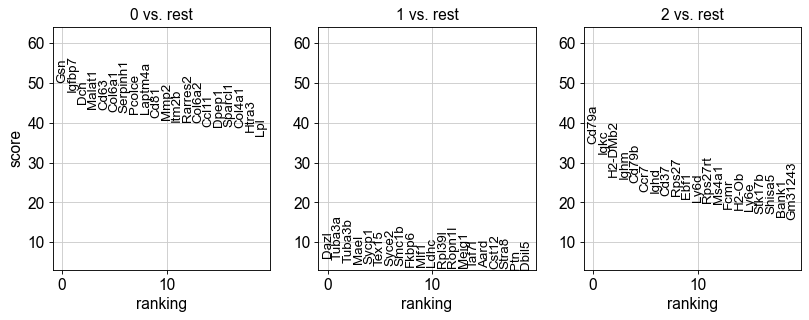

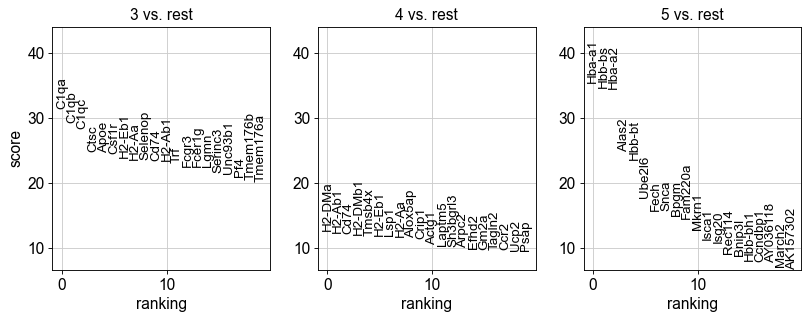

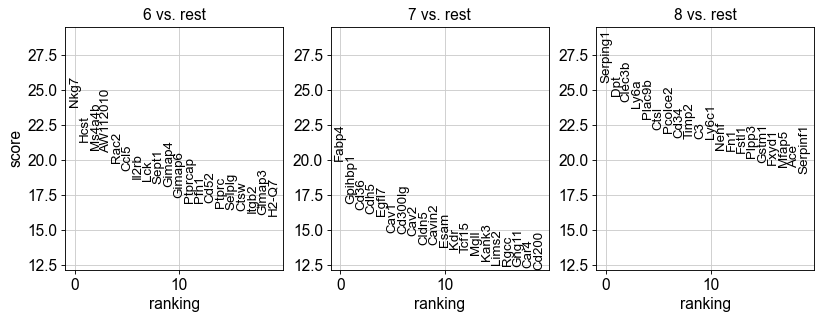

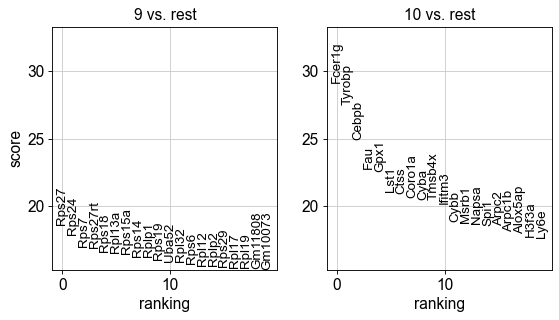

In [29]:
sc.tl.rank_genes_groups(adata_proc, groupby='louvain', key_added='rank_genes')
sc.pl.rank_genes_groups(adata_proc, key='rank_genes', groups=['0','1','2'], fontsize=12, save="_adata_proc_genes_1.svg")
sc.pl.rank_genes_groups(adata_proc, key='rank_genes', groups=['3','4','5'], fontsize=12, save="_adata_proc_genes_2.svg")
sc.pl.rank_genes_groups(adata_proc, key='rank_genes', groups=['6','7','8'], fontsize=12, save="_adata_proc_genes_2.svg")
sc.pl.rank_genes_groups(adata_proc, key='rank_genes', groups=['9','10'], fontsize=12, save="_adata_proc_genes_2.svg")

## Define Marker Sets

Define marker sets for some of the expected cell types and add DE genes.

In [30]:
# Leukocyte markers:
astrocyte_markers = ['Gfap','Aldh1l1','Slc1a2','Slc1a3','Slc27a1']
leukocyte_markers = ['Ptprc','Tcf25']
tc_markers = ['Cd3d','Cd3e','Cd3g','Cd4','Cd8a1','Cd8b','Ms4a4b','Trbc2']
nk_markers = ['Nkg7','Il2rb', 'Ncr1', 'Klrd1', 'Klrb1b', 'Klrb1f']
myeloid_markers = ['Cd79a', 'Itgax', 'Itgam', 'Fcgr3','S100a8', 'S100a9']
mp_markers = ['Adgre1', 'Lyz2','C1qa','Pf4']
dc_markers = ['Cd74', 'Anpep' , 'Cd33', 'Cd80', 'Cd83', 'Cd86'] 
bc_markers = ['Cd19','Igkc','Ighm','Cd79a']
adipocyte_markers = ['Fgf10','Bmp4','Zfp423','Psmb8','Pdgfra', 'Slc7a10', 'Pparg', 'Cd34', 'Dlk1', 'Dpp4', 'Fabp4',
                     'Ucp1', 'Slc36a2', 'Tmem26','Adipoq','Prdm16','Ppargc1a','Tcf25','Bin1','Eif5','Slc2a4',
                     'Cebpa','Lpl','Pnpla2','Plin1'] # 'Slc7a10' is 'Asc1'; Dlk1 is Pref1; Cd29 is Itgb1  ,'P2rd5'
differentialtion_markers = ['Pparg','Cebpa','Cebpb','Cebpd','Dlk1','Fabp4']
megakaryocyte_markers = ['Ppbp']
erythrocyte_markers = ['Gypa','Hba-a2','Hbb-bt','Alas2']
go_adip_dev = ['Aacs', 'Acat1', 'Arid5b','Arrdc3', 'Atf2', 'Bbs4', 'Bdh1', 'Csf1', 'Dgat2','Dyrk1b', 'Ebf2',
               'Fam123b', 'Fto','Hgmcs2', 'Id2', 'Lep', 'Lrp5', 'Nampt', 'Oxct1', 'Paxip1', 'Pik3ca', 'Ppard',
               'Ppargc1a', 'Rorc', 'Sh3pxd2b', 'Slc25a25',  'Sox8', 'Spg20', 'Tbl1xr1', 'Umold1', 'Xbp1', 'Znf516']

Only keep markers occurring in data set.

In [31]:
astrocyte_markers = np.array([x for x in astrocyte_markers if x in adata_proc.var_names])
leukocyte_markers = np.array([x for x in leukocyte_markers if x in adata_proc.var_names])
tc_markers = np.array([x for x in tc_markers if x in adata_proc.var_names])
nk_markers = np.array([x for x in nk_markers if x in adata_proc.var_names])
myeloid_markers = np.array([x for x in myeloid_markers if x in adata_proc.var_names])
mp_markers = np.array([x for x in mp_markers if x in adata_proc.var_names])
dc_markers = np.array([x for x in dc_markers if x in adata_proc.var_names])
bc_markers = np.array([x for x in bc_markers if x in adata_proc.var_names])
megakaryocyte_markers = np.array([x for x in megakaryocyte_markers if x in adata_proc.var_names])
erythrocyte_markers = np.array([x for x in erythrocyte_markers if x in adata_proc.var_names])
adipocyte_markers = np.array([x for x in adipocyte_markers if x in adata_proc.var_names])
differentialtion_markers = np.array([x for x in differentialtion_markers if x in adata_proc.var_names])
go_adip_dev = np.array([x for x in go_adip_dev if x in adata_proc.var_names])

<a id="Plotting"></a>

### Plotting Routines for Markers Gene Sets:

In [32]:
def plot_violin_marker(adata, markers, save=None, use_raw=True):
    for i in range(len(markers) // 2 + len(markers) % 2):
        if save is not None:
            sc.pl.violin(
                adata, 
                groupby='louvain', 
                keys=markers[(2*i):np.min([2*(i+1), len(markers)])], 
                use_raw=use_raw, 
                rotation=90, size=5,
                save=save+"_"+str(i)+".svg"
            )
        else:
            sc.pl.violin(
                adata, 
                groupby='louvain', 
                keys=markers[(2*i):np.min([2*(i+1), len(markers)])], 
                use_raw=use_raw, 
                rotation=90, size=5,
            )
def plot_umap_marker(adata, markers, size=3, save=None, use_raw=True):
    for i in range(len(markers) // 2 + len(markers) % 2):
        print(markers[(2*i):np.min([2*(i+1), len(markers)])])
        if save is not None:
            sc.pl.umap(
                adata, 
                color=markers[(2*i):np.min([2*(i+1), len(markers)])], 
                size=size,
                use_raw=use_raw,
                color_map=mymap,
                save=save+"_"+str(i)+".svg"
            )
        else:
            sc.pl.umap(
                adata, 
                color=markers[(2*i):np.min([2*(i+1), len(markers)])], 
                size=size,
                use_raw=use_raw,
                color_map=mymap
            )

In [33]:
if bool_plot == True:
    plot_violin_marker(adata_proc, astrocyte_markers.tolist())

## Leukocyte Markers

In [34]:
if bool_plot == True:
    plot_violin_marker(adata_proc, leukocyte_markers.tolist(), save="_all_markers_leukocyte")

Cluster 1,9 and 10 show expression for the leukocyte marker Ptprc. Tcf25 found in many clusters.

## Erythrocyte Markers

In [35]:
if bool_plot == True:
    plot_violin_marker(adata_proc, erythrocyte_markers.tolist(), save="_all_markers_erythrcytes")

The haemoglobin markers and Alas2 show high counts in cluster 5 indicating that cluster 5 corresponds to erythrocytes.

<a id="Preadipocyte"></a>

## Preadipocyte Markers

In [36]:
if bool_plot == True:
    plot_violin_marker(adata_proc, adipocyte_markers.tolist(), save="_all_markers_preadipocytes")

## T-Cell Markers

In [37]:
if bool_plot == True:
    plot_violin_marker(adata_proc, tc_markers.tolist(), save="_all_markers_tcells")

T-cell markers are strongly expressed in cluster 6.

<a id="Natural"></a>

## Natural Killer Cells Markers

In [38]:
if bool_plot == True:
    plot_violin_marker(adata_proc, nk_markers.tolist(), save="_all_markers_nk")

NK cell markers are expressed in cluster 6, which is inline with their transcriptomic similarity to T cells which are also found in cluster 6.

## Myeloid Cell Markers

In [39]:
if bool_plot == True:
    plot_violin_marker(adata_proc, myeloid_markers.tolist(), save="_all_markers_myeloid")

## Macrophage Markers

In [40]:
if bool_plot == True:
    plot_violin_marker(adata_proc, mp_markers.tolist(), save="_all_markers_macrophages")

The macrophage markers are strongly expressed in cluster 3.

<a id="Dendridic"></a>

## Dendritic cell Markers

In [41]:
if bool_plot == True:
    plot_violin_marker(adata_proc, dc_markers.tolist(), save="_all_markers_dendritic")

Dendritic cells markers are stongly expressed in cluster 3 and 4.

<a id="B-Cell"></a>

## B-Cell Markers

In [42]:
if bool_plot == True:
    plot_violin_marker(adata_proc, bc_markers.tolist(), save="_all_markers_bcells")

B cell markers are highly expressed in cluster 2.

<a id=heatmap></a>

## Summary Heatmap for cluster assignments

In [43]:
selected_leukocyte_markers = ['Ptprc']
selected_tc_markers = ['Cd3d', 'Cd3g','Cd3e']
selected_nk_markers = ['Nkg7','Klrd1','Ncr1','Il2rb']
selected_myeloid_markers = ['Fcgr3','S100a8']
selected_mp_markers = ['Adgre1', 'C1qa','Pf4']
selected_dc_markers = ['Cd74', 'Cd83','Cd86'] 
selected_bc_markers = ['Cd19','Igkc','Ighm','Cd79a']
selected_adipocyte_markers = ['Pdgfra','Cd34', 'Dlk1','Fabp4','Fgf10','Bmp4','Pparg','Ucp1','Prdm16','Lpl'] # 'Slc7a10' is 'Asc1'; Dlk1 is Pref1; Cd29 is Itgb1
#selected_megakaryocyte_markers = ['Ppbp']
selected_erythrocyte_markers = ['Gypa','Hba-a2','Hbb-bt','Alas2']

In [44]:
selected_cell_markers = selected_leukocyte_markers + \
selected_erythrocyte_markers + \
selected_myeloid_markers + \
selected_mp_markers + \
selected_dc_markers + \
selected_bc_markers + \
selected_tc_markers + \
selected_nk_markers + \
selected_adipocyte_markers

In [45]:
if bool_plot==True:
    sc.pl.heatmap(
        adata=adata_proc, 
        var_names=selected_cell_markers, 
        groupby="louvain", 
        use_raw=False, 
        log=False, 
        dendrogram=True, 
        var_group_rotation=90, 
        show_gene_labels=True, 
        show=True, 
        save="_all_markers_celltypes.svg"
    )

## UMAP with assigned cell types

In [46]:
new_cluster_names = {
    '0': "preadipocytes",
    '1': "low expression",
    '2': "lymphoid (B cell)",
    '3': "myeloid (DC, macrophage)",
    '4': "myeloid (DC)",
    '5': "erythrocytes",
    '6': "lymphoid (TC, NK)",
    '7': "adipocytes",
    '8': "preadipocytes",
    '9': "lymphoid (TC)",
    '10': "myeloid (macrophage)",
    '11': "myeloid (s100a8 high)"
}
adata_proc.obs['celltypes'] = [new_cluster_names[x] for x in  adata_proc.obs['louvain']]
if bool_plot == True:
    sc.pl.umap(adata_proc, size=5, color=['celltypes'], save="_all_louvain_named.svg")
    sc.pl.paga(adata_proc, color=['celltypes'], save="_all_named.svg")
    #sc.pl.umap(adata_proc, size=5, color=adipocyte_markers)

<a id="adipocytes"></a>

# Adipocytes only

<a id="Embedding"></a>

## Embedding and Clustering

In [47]:
if bool_recomp == True:  
    cell_ids_adip = np.asarray(adata_proc.obs_names)[
        [x in ['preadipocytes','adipocytes'] 
         for x in np.asarray(adata_proc.obs['celltypes'].values)]
    ]
    adata_adip = adata_raw[cell_ids_adip,:].copy()
    adata_adip.obs['n_genes'] = (adata_adip.X > 0).sum(1)
    mt_gene_mask = [gene.startswith('mt-') for gene in adata_adip.var_names]
    temp_mt_sum = adata_adip[:,mt_gene_mask].X.sum(1)
    temp_mt_sum = np.squeeze(np.asarray(temp_mt_sum))
    temp_n_counts = adata_adip.obs['n_counts']
    adata_adip.obs['mt_frac'] = temp_mt_sum/adata_adip.obs['n_counts']
    adata_adip.raw = adata_adip
    sc.pp.normalize_per_cell(adata_adip)
    sc.pp.log1p(adata_adip)
    sc.pp.highly_variable_genes(adata_adip,n_top_genes=4000)
    sc.pl.highly_variable_genes(adata_adip)
    sc.pp.pca(adata_adip, n_comps=50, use_highly_variable = True, random_state=0, svd_solver='arpack')
    sc.pp.neighbors(adata_adip, n_neighbors=100, knn=True, method='umap', n_pcs=50, random_state=0)
    sc.tl.umap(adata_adip)
    if bool_recluster == True:
        sc.tl.louvain(adata_adip, resolution=1, flavor='vtraag', random_state=0)
        pd.DataFrame(adata_adip.obs).to_csv(path_or_buf=dir_adata+'obs_adata_adip.csv')
    else:
        obs = pd.read_csv(dir_adata+'obs_adata_adip.csv')
        adata_adip.obs['louvain']=pd.Series(obs['louvain'].values, dtype = 'category')
    sc.write(dir_adata+'adata_adip.h5ad',adata_adip)
else:
    adata_adip = sc.read(dir_adata+'adata_adip.h5ad') 
sc.tl.paga(adata_adip)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


In [48]:
if bool_plot == True:
    sc.pl.umap(adata_adip, color=['louvain','mt_frac'], size=30, save="_adipocytes_louvain_0.svg", color_map=mymap)
    sc.pl.umap(adata_adip, color=['n_genes','n_counts'], size=30, save="_adipocytes_louvain_1.svg", color_map=mymap)
    sc.pl.paga(adata_adip, color=['louvain','n_counts'], save="_adipocytes_louvain.svg")

Cluster 0,1,3 (top) shows many more counts than cluster 2 (bottom).

<a id="adipmarkers"></a>

## Adipocyte Marker Analysis

In [49]:
if bool_plot == True:
    plot_violin_marker(adata_adip, adipocyte_markers.tolist(), save="_adipo_markers_adipocytes", use_raw=False)

FABP4 is present only in cluster 2. Together with Pparg expression in cluster 2, it can be concluded that cluster 2 represents mature adipocytes instead of preadipocytes. Clusters 0,1 and 3 express multiple preadpocyte markers.

In [50]:
if bool_plot==True:
    sc.pl.heatmap(
        adata=adata_adip, 
        var_names=adipocyte_markers, 
        groupby="louvain", 
        use_raw=False, 
        log=False, 
        dendrogram=True, 
        var_group_rotation=90, 
        show_gene_labels=True, 
        show=True, 
        save="_adipocyte_markers_celltypes_in_adipocytes.svg"
    )

<a id="topde"></a>

## Top ranking DE Genes

In [51]:
sc.tl.rank_genes_groups(adata_adip, groupby='louvain', n_genes=4000, key_added='rank_genes')
if bool_plot == True:
    sc.pl.rank_genes_groups(adata_adip, key='rank_genes', groups=['0','1','2','3'], fontsize=12, save="_adipocytes.svg")

ranking genes
    finished: added to `.uns['rank_genes']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [52]:
result = adata_adip.uns['rank_genes']
groups = result['names'].dtype.names
diffExp = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']}).head(4000)

In [53]:
diffExp.columns = ['0_name','0_pval_ajd','0_logFC','1_name','1_pval_ajd','1_logFC','2_name','2_pval_ajd','2_logFC',
                   '3_name','3_pval_ajd','3_logFC']

In [54]:
diffExp.head(200)

,0_name,0_pval_ajd,0_logFC,1_name,1_pval_ajd,1_logFC,2_name,2_pval_ajd,2_logFC,3_name,3_pval_ajd,3_logFC
0,Smoc2,7.757335e-94,22.647722,Serpinf1,1.628083e-38,21.520140,Fabp4,5.219898e-53,68.067513,Fn1,1.471680e-43,16.404730
1,Ccl11,9.647686e-87,20.820154,Gpx3,5.501323e-36,37.284767,Cd36,1.515094e-44,8.151485,Pi16,1.588949e-39,72.185143
2,Cd81,9.647686e-87,22.623253,Rps28,5.111517e-28,10.813704,Gpihbp1,1.058415e-42,10.048880,Pcolce2,1.240471e-37,9.054131
3,Col15a1,1.041340e-74,7.893826,Col3a1,1.055288e-25,59.185322,Egfl7,1.147110e-38,7.234115,Cd248,7.553082e-37,7.779716
4,Sparcl1,2.999908e-72,9.077395,Tmsb10,4.004513e-26,23.602446,Cdh5,8.853397e-38,6.453962,Igfbp6,2.067932e-35,39.631252
...,...,...,...,...,...,...,...,...,...,...,...,...
195,AW112010,2.830061e-14,3.460990,mt-Co1,2.724730e-12,7.749297,Hhex,3.830902e-04,2.231366,Agpat4,3.918617e-11,1.984396
196,Thbs1,1.257638e-13,2.611183,Junb,4.239111e-12,20.283936,Kif26a,4.400375e-04,4.292553,Eef2,3.817158e-11,3.708905
197,Ank2,1.418408e-13,1.969057,Lamb2,7.714412e-12,2.257870,Caskin2,4.436402e-04,1.763136,Pfdn5,3.039890e-11,2.067778
198,Prdx1,9.510255e-14,2.481491,Neat1,4.738779e-12,2.430741,Sigirr,5.006762e-04,2.662978,Triobp,6.163536e-11,2.063323


In [55]:
# save a DE table
diffExp.to_csv(path_or_buf=dir_tables+"DE_adipocytes_by_cluster.csv", sep="\t")

<a id="marker_counts"></a>

### Marker Counts Raw and Normalized

In [56]:
if bool_plot == True:
    plot_umap_marker(adata_adip, adipocyte_markers, size=50, save="_preadip_markers_adipocytes_raw", use_raw=True)

In [57]:
if bool_plot == True:
    plot_umap_marker(adata_adip, adipocyte_markers, size=50, save="_preadip_markers_adipocytes_norm", use_raw=False)

<a id="count_dist"></a>

## Count distribution for Tcf25, Bin1 and Eif5

<a id="countspg"></a>

### Single Double and Triple Positive Counts

Define booleans for single, double and triple positive counts of bin1, eif5 and tcf25

In [60]:
if bool_recomp == True:  
    non_boolean_int = np.array((adata_adip[:,'Bin1'].X<=0) & (adata_adip[:,'Eif5'].X<=0) & (adata_adip[:,'Tcf25'].X<=0), dtype=int)

    bin1_single_boolean = (adata_adip[:,'Bin1'].X>0) & (adata_adip[:,'Eif5'].X<=0) & (adata_adip[:,'Tcf25'].X<=0)
    eif5_single_boolean = (adata_adip[:,'Eif5'].X>0) & (adata_adip[:,'Bin1'].X<=0) & (adata_adip[:,'Tcf25'].X<=0)
    tcf25_single_boolean = (adata_adip[:,'Tcf25'].X>0) & (adata_adip[:,'Eif5'].X<=0) & (adata_adip[:,'Bin1'].X<=0)
    single_boolean_int = np.array((bin1_single_boolean | eif5_single_boolean | tcf25_single_boolean), dtype=int)*1

    bin1_eif5_double_boolean = (adata_adip[:,'Bin1'].X>0) & (adata_adip[:,'Eif5'].X>0) & (adata_adip[:,'Tcf25'].X<=0)
    bin1_tcf25_double_boolean = (adata_adip[:,'Eif5'].X<=0) & (adata_adip[:,'Bin1'].X>0) & (adata_adip[:,'Tcf25'].X>0)
    tcf25_eif5_double_boolean = (adata_adip[:,'Tcf25'].X>0) & (adata_adip[:,'Eif5'].X>0) & (adata_adip[:,'Bin1'].X<=0)
    double_boolean_int = np.array((bin1_eif5_double_boolean | bin1_tcf25_double_boolean | tcf25_eif5_double_boolean), dtype=int)*2

    triple_boolean = (adata_adip[:,'Tcf25'].X>0) & (adata_adip[:,'Eif5'].X>0) & (adata_adip[:,'Bin1'].X>0)
    triple_boolean_int = np.array(triple_boolean, dtype=int)*3
    non_boolean_int *=0

In [61]:
if bool_recomp == True: 
    bin1_single_pos = adata_adip[:,'Bin1'].X[bin1_single_boolean]
    eif5_single_pos = adata_adip[:,'Eif5'].X[eif5_single_boolean]
    tcf25_single_pos = adata_adip[:,'Tcf25'].X[tcf25_single_boolean]

    print('Bin1 Single Positive ',len(bin1_single_pos))
    print('eif5 Single Positive ',len(eif5_single_pos))
    print('tcf25 Single Positive ',len(tcf25_single_pos))

    bin1_eif5_double_pos = adata_adip[:,'Bin1'].X[bin1_eif5_double_boolean]
    bin1_tcf25_double_pos = adata_adip[:,'Eif5'].X[bin1_tcf25_double_boolean]
    tcf25_eif5_double_pos = adata_adip[:,'Tcf25'].X[tcf25_eif5_double_boolean]

    print('Bin1/Eif5 Double Positive ',len(bin1_eif5_double_pos))
    print('Bin1/Tcf25 Double Positive ',len(bin1_tcf25_double_pos))
    print('Tcf25/Eif5 Double Positive ',len(tcf25_eif5_double_pos))

    triple_pos = adata_adip[:,'Bin1'].X[triple_boolean]
    print('Triple Positive ',len(triple_pos))

Define observations for single, double and triple positive counts of bin1, eif5 and tcf25

In [62]:
if bool_recomp == True:
    adata_adip.obs['sdt_pos'] = np.array((non_boolean_int + single_boolean_int + double_boolean_int + triple_boolean_int), dtype=str)
    adata_adip.obs['s_pos'] = np.array((np.array(bin1_single_boolean, dtype=int)*1)+(np.array(eif5_single_boolean, dtype=int)*2)+(np.array(tcf25_single_boolean, dtype=int)*3), dtype=str)
    adata_adip.obs['d_pos'] = np.array((np.array(bin1_eif5_double_boolean, dtype=int)*1)+(np.array(bin1_tcf25_double_boolean, dtype=int)*2)+(np.array(tcf25_eif5_double_boolean, dtype=int)*3), dtype=str)
    adata_adip.obs['t_pos'] = np.array(triple_boolean, dtype=str)
    # make them categorical
    adata_adip.obs['sdt_pos'] = pd.Series(adata_adip.obs['sdt_pos'], dtype="category")
    adata_adip.obs['s_pos'] = pd.Series(adata_adip.obs['s_pos'], dtype="category")
    adata_adip.obs['d_pos'] = pd.Series(adata_adip.obs['d_pos'], dtype="category")
    adata_adip.obs['t_pos'] = pd.Series(adata_adip.obs['t_pos'], dtype="category")

In [63]:
if bool_plot == True:
    new_cluster_names = ['Non Positives','Single Positives','Double Positives','Triple Positives']
    adata_adip.rename_categories('sdt_pos', new_cluster_names)
    sc.pl.umap(adata_adip, color=['sdt_pos'], size=20, save="_non-single-double-triple_positive.svg")
    new_cluster_names = ['Non Single Positives','Bin1 Single Positives','Eif5 Single Positives','Tcf25 Single Positives']
    adata_adip.rename_categories('s_pos', new_cluster_names)
    sc.pl.umap(adata_adip[adata_adip.obs['s_pos']!='Non Single Positives'], color=['s_pos'], size=20, save="_Bin1_Eif5_Tcf25_single_positive.svg")
    new_cluster_names = ['Non Double Positives','Bin1/Eif5 Double Positive','Bin1/Tcf25 Double Positive','Tcf25/Eif5 Double Positive']
    adata_adip.rename_categories('d_pos', new_cluster_names)
    sc.pl.umap(adata_adip[adata_adip.obs['d_pos']!='Non Double Positives'], color=['d_pos'], size=20,save="_Bin1Eif5-Bin1Tcf25-Tcf25Eif5_double_positive.svg")
    new_cluster_names = ['Non Triple Positives','Triple Positives']
    adata_adip.rename_categories('t_pos', new_cluster_names)
    sc.pl.umap(adata_adip[adata_adip.obs['t_pos']!='Non Triple Positives'], color=['t_pos'], size=20,
               save="_triple_positive.svg")
 


Single positives are found in all 4 clusters. Double positives are mostly in the clusters 0,1 and 3 (preadipocyte clusters) and far less present in cluster 2 (mature adipocyte cluster). Triple positives are found only in clusters 0,1 and 3 with only one exception.

### Analysis separately for preadipocytes and mature adipocytes

In [64]:
adata_adip.obs['louvain'].head()
adata_preadip = adata_adip[adata_adip.obs['louvain']!='2']
adata_matadip = adata_adip[adata_adip.obs['louvain']=='2']

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Preadipocyte clusters (0,1,3)

In [65]:
if bool_plot == True:
    sc.pl.umap(adata_preadip, color=['sdt_pos'], size=20)
    sc.pl.umap(adata_preadip[adata_preadip.obs['s_pos']!='Non Single Positives'], color=['s_pos'], size=20)
    sc.pl.umap(adata_preadip[adata_preadip.obs['d_pos']!='Non Double Positives'], color=['d_pos'], size=20)
    sc.pl.umap(adata_preadip[adata_preadip.obs['t_pos']!='Non Triple Positives'], color=['t_pos'], size=20)

In [66]:
if bool_plot == True:
    import matplotlib_venn

    bin1_pos = adata_preadip.obs_names[np.asarray(adata_preadip[:,'Bin1'].X).flatten()>0]
    eif5_pos = adata_preadip.obs_names[np.asarray(adata_preadip[:,'Eif5'].X).flatten()>0]
    tcf25_pos = adata_preadip.obs_names[np.asarray(adata_preadip[:,'Tcf25'].X).flatten()>0]

    matplotlib_venn.venn3([
        set(bin1_pos),
        set(eif5_pos),
        set(tcf25_pos)
    ], set_labels = ("Bin1", "Eif5", "Tcf25"))
    plt.savefig(dir_out + "panels/venn_target_positives_adipocytes.svg")

Mature adipocyte cluster

In [67]:
if bool_plot == True:
    sc.pl.umap(adata_matadip, color=['sdt_pos'], size=20)
    sc.pl.umap(adata_matadip[adata_matadip.obs['s_pos']!='Non Single Positives'], color=['s_pos'], size=20)
    sc.pl.umap(adata_matadip[adata_matadip.obs['d_pos']!='Non Double Positives'], color=['d_pos'], size=20)
    sc.pl.umap(adata_matadip[adata_matadip.obs['t_pos']!='Non Triple Positives'], color=['t_pos'], size=20)

<a id="means"></a>

In [68]:
if bool_plot == True:
    import matplotlib_venn

    bin1_pos = adata_matadip.obs_names[np.asarray(adata_matadip[:,'Bin1'].X).flatten()>0]
    eif5_pos = adata_matadip.obs_names[np.asarray(adata_matadip[:,'Eif5'].X).flatten()>0]
    tcf25_pos = adata_matadip.obs_names[np.asarray(adata_matadip[:,'Tcf25'].X).flatten()>0]

    matplotlib_venn.venn3([
        set(bin1_pos),
        set(eif5_pos),
        set(tcf25_pos)
    ], set_labels = ("Bin1", "Eif5", "Tcf25"))
    plt.savefig(dir_out + "panels/venn_target_positives_mature_adipocytes.svg")

### Mean Counts

Normalized

In [69]:
print('Bin1 mean counts: ',np.mean(adata_adip[:,'Bin1'].X))
print('Eif5 mean counts: ',np.mean(adata_adip[:,'Eif5'].X))
print('Tcf25 mean counts: ',np.mean(adata_adip[:,'Tcf25'].X))

Bin1 mean counts:  0.23998265
Eif5 mean counts:  0.6047478
Tcf25 mean counts:  0.37402338


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


<a id="traject"></a>

# Preadipocytes only

In [70]:
if bool_recomp == True:
    cell_ids_adip2 = np.asarray(adata_proc.obs_names)[
        [x in ['preadipocytes'] 
         for x in np.asarray(adata_proc.obs['celltypes'].values)]
    ]
    adata_adip2 = adata_raw[cell_ids_adip2,:].copy()
    adata_adip2.obs['n_genes'] = (adata_adip2.X > 0).sum(1)
    temp_n_counts2 = adata_adip2.obs['n_counts']
    adata_adip2.raw = adata_adip2
    adata_adip2.obs['louvain_old'] = adata_proc[cell_ids_adip2, :].obs['louvain']
    sc.pp.normalize_per_cell(adata_adip2)
    sc.pp.log1p(adata_adip2)
    sc.pp.highly_variable_genes(adata_adip2,n_top_genes=4000)
    sc.pl.highly_variable_genes(adata_adip2)
    sc.pp.pca(adata_adip2, n_comps=50, use_highly_variable = True, random_state=0, svd_solver='arpack')
    sc.pp.neighbors(adata_adip2, n_neighbors=100, knn=True, method='umap', n_pcs=50, random_state=0)
    sc.tl.umap(adata_adip2)
    if bool_recluster == True:
        sc.tl.louvain(adata_adip2, resolution=1, flavor='vtraag', random_state=0)
        pd.DataFrame(adata_adip2.obs).to_csv(path_or_buf=dir_adata+'obs_adata_adip2.csv')
    else:
        obs2 = pd.read_csv(dir_adata+'obs_adata_adip2.csv')
        adata_adip2.obs['louvain']=pd.Series(obs2['louvain'].values, dtype = 'category')
    sc.write(dir_adata+'adata_adip2.h5ad',adata_adip2)
else:
    adata_adip2 = sc.read(dir_adata+'adata_adip2.h5ad') 
sc.tl.paga(adata_adip2)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


In [71]:
if bool_plot == True:
    sc.pl.umap(adata_adip2, color=['louvain_old', 'louvain'], size=30, save="_preadipocytes_louvain_0.svg")
    sc.pl.paga(adata_adip2, color=['louvain'], save="_preadipocytes_louvain.svg")

In [72]:
if bool_plot == True:
    plot_umap_marker(adata_adip2, differentialtion_markers, size=50, save="_differentialtion_markers_preadipcytes", use_raw=False)

In [73]:
if bool_plot == True:
    plot_umap_marker(adata_adip2, adipocyte_markers, size=50, save="_preadip_markers_preadipcytes", use_raw=False)

In [74]:
if bool_plot == True:
    plot_violin_marker(adata_adip, differentialtion_markers.tolist(), save="_differentialtion_markers_preadipcytes", use_raw=False)

In [75]:
if bool_plot==True:
    sc.pl.heatmap(
        adata=adata_adip2, 
        var_names=differentialtion_markers, 
        groupby="louvain", 
        use_raw=False, 
        log=False, 
        dendrogram=True, 
        var_group_rotation=90, 
        show_gene_labels=True, 
        show=True, 
        save="_differentialtion_markers_celltypes_preadipocytes.svg"
    )

In [76]:
if bool_plot==True:
    sc.pl.heatmap(
        adata=adata_adip2, 
        var_names=adipocyte_markers, 
        groupby="louvain", 
        use_raw=False, 
        log=False, 
        dendrogram=True, 
        var_group_rotation=90, 
        show_gene_labels=True, 
        show=True, 
        save="_preadipocyte_markers_celltypes_preadipocytes.svg"
    )

In [77]:
sc.tl.rank_genes_groups(adata_adip2, groupby='louvain', n_genes=4000, key_added='rank_genes')
if bool_plot == True:
    sc.pl.rank_genes_groups(adata_adip2, key='rank_genes', groups=['0','1','2','3'], fontsize=12, save="_preadipocytes.svg")

ranking genes
    finished: added to `.uns['rank_genes']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [78]:
result = adata_adip2.uns['rank_genes']
groups = result['names'].dtype.names
diffExp = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']}).head(4000)

In [79]:
diffExp.columns = ['0_name','0_pval_ajd','0_logFC','1_name','1_pval_ajd','1_logFC','2_name','2_pval_ajd','2_logFC',
                   '3_name','3_pval_ajd','3_logFC']

In [80]:
diffExp.head(200)

,0_name,0_pval_ajd,0_logFC,1_name,1_pval_ajd,1_logFC,2_name,2_pval_ajd,2_logFC,3_name,3_pval_ajd,3_logFC
0,Ccl11,2.404488e-60,18.707151,Col4a1,8.017118e-20,8.458212,Fn1,1.832429e-43,16.013220,Fbln1,9.266523e-14,8.055276
1,Smoc2,2.364672e-57,18.905619,Col6a3,8.242973e-19,7.673200,Pi16,6.511683e-40,71.567375,Cd9,4.457199e-11,5.927159
2,Cd81,8.357925e-57,19.137293,Col4a2,5.313370e-19,4.610971,Anxa3,2.041709e-35,8.416794,Tgfbi,6.926899e-11,6.571140
3,Sparcl1,1.210721e-43,7.845957,Ctsk,1.918070e-17,5.106206,Pcolce2,2.084237e-36,8.423483,Gpx3,1.504046e-10,37.076443
4,Crispld2,1.468633e-39,4.460745,Col5a3,5.797810e-18,4.417149,Ly6c1,9.967122e-37,10.407754,Ltbp4,2.297316e-10,3.293560
...,...,...,...,...,...,...,...,...,...,...,...,...
195,Scp2,3.230899e-06,1.028394,C1ra,8.325393e-02,0.982906,Rpl8,4.620981e-07,3.741383,Rps27a,1.104486e-02,3.088989
196,Mxra8,3.620009e-06,1.126809,P3h1,8.383255e-02,0.736376,Rpl19,4.692776e-07,3.772483,Txn1,1.197578e-02,1.706663
197,Vasp,3.984479e-06,1.123897,Mme,8.421832e-02,0.850300,Olfml2b,5.565044e-07,1.553335,Angptl1,1.321234e-02,3.079686
198,Prelp,3.939734e-06,1.372811,Acot13,8.421832e-02,0.898456,Gm10076,5.265490e-07,3.055111,Tagln2,1.291772e-02,1.183999


In [81]:
# save a DE table
diffExp.to_csv(path_or_buf=dir_tables+"DE_preadipocytes_by_cluster.csv", sep="\t")

In [82]:
gp = GProfiler(return_dataframe=True)
cluster_0=gp.profile(organism='mmusculus', query=diffExp['0_name'][1:676].tolist())
cluster_1=gp.profile(organism='mmusculus', query=diffExp['1_name'][1:93].tolist())
cluster_2=gp.profile(organism='mmusculus', query=diffExp['2_name'][1:467].tolist())
cluster_3=gp.profile(organism='mmusculus', query=diffExp['3_name'][1:129].tolist())
#cluster_0.sort_values(by='recall', ascending=True)

In [83]:
cluster_0.to_csv(path_or_buf=dir_tables+"enrichment_DE_genes_cluster_0.csv", sep="\t")
cluster_1.to_csv(path_or_buf=dir_tables+"enrichment_DE_genes_cluster_1.csv", sep="\t")
cluster_2.to_csv(path_or_buf=dir_tables+"enrichment_DE_genes_cluster_2.csv", sep="\t")
cluster_3.to_csv(path_or_buf=dir_tables+"enrichment_DE_genes_cluster_3.csv", sep="\t")

## Diffusion Pseudotime Adipocytes¶

In [84]:
adata_adip_raw = adata_adip.copy()
adata_adip_raw.X = adata_adip.raw.X.copy()
sc.pp.log1p(adata_adip_raw)
sc.pp.neighbors(adata_adip_raw)
sc.tl.diffmap(adata_adip_raw)

sc.pp.neighbors(adata_adip)
sc.tl.diffmap(adata_adip)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.989646   0.98074245 0.95198727 0.9318196  0.9060198
     0.8811513  0.877778   0.86690754 0.8443195  0.84319466 0.81539434
     0.80603105 0.779319   0.7653546 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:

In [85]:
def plot_diffmap_marker(adata, markers, save=None, use_raw=True):
    for i in range(len(markers) // 2 + len(markers) % 2):
        print(markers[(2*i):np.min([2*(i+1), len(markers)])])
        if save is not None:
            sc.pl.diffmap(
                adata, 
                components = '1,2',
                color=markers[(2*i):np.min([2*(i+1), len(markers)])], 
                use_raw=use_raw,
                color_map=mymap,
                save=save+"_"+str(i)+".svg"
            )
        else:
            sc.pl.diffmap(
                adata, 
                components,
                color=markers[(2*i):np.min([2*(i+1), len(markers)])], 
                use_raw=use_raw,
                color_map=mymap
            )

In [86]:
if bool_plot == True:
    sc.pl.diffmap(adata_adip, components='1,2', color='louvain', save="_adipocytes_pseudotime_louvain_DC_1-2_norm.svg")
    sc.pl.diffmap(adata_adip, components='1,3', color='louvain', save="_adipocytes_pseudotime_louvain_DC_1-3_norm.svg")
    sc.pl.diffmap(adata_adip_raw, components='1,2', color='louvain', save="_adipocytes_pseudotime_louvain_DC_1-2.svg")
    sc.pl.diffmap(adata_adip_raw, components='1,3', color='louvain', save="_adipocytes_pseudotime_louvain_DC_1-3.svg")

In [87]:
adipocyte_mask21 = np.isin(adata_adip.obs['louvain'], '0')
max_adipocyte_id21 = np.argmax(adata_adip.obsm['X_diffmap'][adipocyte_mask21,2])
max_adipocyte_id2_raw1 = np.argmax(adata_adip.obsm['X_diffmap'][adipocyte_mask21,2])
root_id21 = np.arange(len(adipocyte_mask21))[adipocyte_mask21][max_adipocyte_id21]
adata_adip.uns['iroot'] = root_id21
adata_adip_raw.uns['iroot'] = root_id21

#Compute dpt
sc.tl.dpt(adata_adip, n_branchings = 0)
sc.tl.dpt(adata_adip_raw, n_branchings = 0)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [88]:
if bool_plot == True:
    plot_diffmap_marker(adata_adip, adipocyte_markers, save="_adipocytes_pseudotime_adipocyte_markers_DC_1-2_norm")
    plot_diffmap_marker(adata_adip_raw, adipocyte_markers, save="_adipocytes_pseudotime_adipocyte_markers_DC_1-2")

In [89]:
#Visualize pseudotime over differentiation
if bool_plot == True:
    sc.pl.diffmap(adata_adip, components='1,2', color='dpt_pseudotime', color_map=mymap, save="_adipocytes_dpt_pseudotime_DC_1-2_norm.svg")
    sc.pl.diffmap(adata_adip, components='1,3', color='dpt_pseudotime', color_map=mymap, save="_adipocytes_dpt_pseudotime_DC_1-3_norm.svg")
    sc.pl.diffmap(adata_adip_raw, components='1,2', color='dpt_pseudotime', color_map=mymap, save="_adipocytes_dpt_pseudotime_DC_1-2.svg")
    sc.pl.diffmap(adata_adip_raw, components='1,3', color='dpt_pseudotime', color_map=mymap, save="_adipocytes_dpt_pseudotime_DC_1-3.svg")
    

## Diffusion Pseudotime Preadipocytes¶

In [90]:
adata_adip2_raw = adata_adip2.copy()
adata_adip2_raw.X = adata_adip2.raw.X.copy()
sc.pp.log1p(adata_adip2_raw)
sc.pp.neighbors(adata_adip2_raw)
sc.tl.diffmap(adata_adip2_raw)

sc.pp.neighbors(adata_adip2)
sc.tl.diffmap(adata_adip2)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.981316   0.9460798  0.91849977 0.89427274 0.86765224
     0.8456241  0.82347286 0.80268925 0.78898954 0.76468396 0.7550992
     0.7451544  0.7367611  0.7321832 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:

In [91]:
if bool_plot == True:
    sc.pl.diffmap(adata_adip2, components='1,2', color='louvain', save="_preadipocytes_pseudotime_louvain_DC_1-2_norm.svg")
    sc.pl.diffmap(adata_adip2, components='1,3', color='louvain', save="_preadipocytes_pseudotime_louvain_DC_1-3_norm.svg")
    sc.pl.diffmap(adata_adip2_raw, components='1,2', color='louvain', save="_preadipocytes_pseudotime_louvain_DC_1-2.svg")
    sc.pl.diffmap(adata_adip2_raw, components='1,3', color='louvain', save="_preadipocytes_pseudotime_louvain_DC_1-3.svg")

In [92]:
adipocyte_mask2 = np.isin(adata_adip2.obs['louvain'], '0')
max_adipocyte_id2 = np.argmax(adata_adip2.obsm['X_diffmap'][adipocyte_mask2,2])
max_adipocyte_id2_raw = np.argmax(adata_adip2.obsm['X_diffmap'][adipocyte_mask2,2])
root_id2 = np.arange(len(adipocyte_mask2))[adipocyte_mask2][max_adipocyte_id2]
adata_adip2.uns['iroot'] = root_id2
adata_adip2_raw.uns['iroot'] = root_id2

#Compute dpt
sc.tl.dpt(adata_adip2, n_branchings = 0)
sc.tl.dpt(adata_adip2_raw, n_branchings = 0)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [93]:
if bool_plot == True:
    plot_diffmap_marker(adata_adip2, adipocyte_markers, save="_preadipocytes_pseudotime_adipocyte_markers_DC_1-2_norm")
    plot_diffmap_marker(adata_adip2_raw, adipocyte_markers, save="_preadipocytes_pseudotime_adipocyte_markers_DC_1-2")

In [94]:
#Visualize pseudotime over differentiation
if bool_plot == True:
    sc.pl.diffmap(adata_adip2, components='1,2', color='dpt_pseudotime', color_map=mymap, save="_preadipocytes_dpt_pseudotime_DC_1-2_norm.svg")
    sc.pl.diffmap(adata_adip2, components='1,3', color='dpt_pseudotime', color_map=mymap, save="_preadipocytes_dpt_pseudotime_DC_1-3_norm.svg")
    sc.pl.diffmap(adata_adip2_raw, components='1,2', color='dpt_pseudotime', color_map=mymap, save="_preadipocytes_dpt_pseudotime_DC_1-2.svg")
    sc.pl.diffmap(adata_adip2_raw, components='1,3', color='dpt_pseudotime', color_map=mymap, save="_preadipocytes_dpt_pseudotime_DC_1-3.svg")
    

In [95]:
#Visualize pseudotime over differentiation
if bool_plot == True:
    sc.pl.diffmap(adata_adip2_raw, components='1,2', color=['Pparg','Cebpa','Cebpb','Cebpd','Dlk1','Fabp4','Cd34','louvain'], color_map=mymap)

In [96]:
if bool_plot == True:
    plot_violin_marker(adata_adip2, ['Pparg','Cebpa','Cebpb','Cebpd','Dlk1','Fabp4','Cd34'], use_raw=False, save="_Nature-rebuttal_differentialtion_markers_preadipcytes.svg")

In [97]:
if bool_plot == True:
    plot_violin_marker(adata_adip, ['Pparg','Cebpa','Cebpb','Cebpd','Dlk1','Fabp4'], use_raw=False, save="_Nature-rebuttal_differentialtion_markers_adipcytes.svg")